<img src=images/logo.png align='right' width=200>

# Time Series Aggregations

## Goal

Our next step is to get introduced to a real time series dataset and learn some fundamental analysis techniques.

We shall first focus on how to group the data by time periods.

## Program
- [Reading in Time Series Data](#read)
- [Aggregations: `resample()`](#agg1)
- [Aggregations: `transform()`](#agg2)
- [Summary](#sum)


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

<a id='read'></a>

## Reading in Time Series Data
<img src=images/plug.jpeg  width=200>

Throughout the this notebook we will use the *household power consumption* dataset. It comes from [UCI ML repo](https://archive.ics.uci.edu/ml/datasets/individual+household+electric+power+consumption) and contains detailed power consumption time series data of a single household in Paris between 2006 and 2010.

In [2]:
power = pd.read_csv('data/household_power_consumption.csv')
power.head()

,ts,consumption
0,2006-12-16 17:24:00,52.266667
1,2006-12-16 17:25:00,72.333333
2,2006-12-16 17:26:00,70.566667
3,2006-12-16 17:27:00,71.800000
4,2006-12-16 17:28:00,43.100000


Notice how our time data is currently recognised as strings.

In [3]:
power.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 2 columns):
 #   Column       Dtype  
---  ------       -----  
 0   ts           object 
 1   consumption  float64
dtypes: float64(1), object(1)
memory usage: 31.7+ MB


Typically timestamp data is contained in a separate column of standard strings. However, we want to make it machine-readable. In order to achieve this, we can set `parse_dates` with the list of columns to be converted to Pandas timestamp when reading the data with `pd.read_csv`. This automatically identifies the format of the dates. 

In [4]:
power = pd.read_csv('data/household_power_consumption.csv', parse_dates=['ts'])
power.head()

,ts,consumption
0,2006-12-16 17:24:00,52.266667
1,2006-12-16 17:25:00,72.333333
2,2006-12-16 17:26:00,70.566667
3,2006-12-16 17:27:00,71.800000
4,2006-12-16 17:28:00,43.100000


In [5]:
power.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 2 columns):
 #   Column       Dtype         
---  ------       -----         
 0   ts           datetime64[ns]
 1   consumption  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 31.7 MB


Explicit formatting may be a good idea if we suspect possible errors and non-standard formats in some of the rows. This will ensure that we get an error message if any value does not match our specified format.

In [6]:
power_unformatted = pd.read_csv('data/household_power_consumption.csv')
(
    power_unformatted
    .assign(ts = pd.to_datetime(power_unformatted['ts'], format='%Y-%m-%d %H:%M:%S'))
)

,ts,consumption
0,2006-12-16 17:24:00,52.266667
1,2006-12-16 17:25:00,72.333333
2,2006-12-16 17:26:00,70.566667
3,2006-12-16 17:27:00,71.800000
4,2006-12-16 17:28:00,43.100000
...,...,...
2075254,2010-11-26 20:58:00,15.766667
2075255,2010-11-26 20:59:00,15.733333
2075256,2010-11-26 21:00:00,15.633333
2075257,2010-11-26 21:01:00,15.566667


We can then access information in the dataset using standard Pandas techniques. 

Below we demonstrate how to select all the data recorded on 17th December 2006.

In [10]:
pd.Timestamp('2006-12-17')

Timestamp('2006-12-17 00:00:00')

In [9]:
(
    power
    .loc[(power['ts'] == pd.Timestamp('2006-12-17')) ]
)

,ts,consumption
396,2006-12-17,15.4


In [7]:
(
    power
    .loc[(power['ts'] >= pd.Timestamp('2006-12-17')) &
         (power['ts'] < pd.Timestamp('2006-12-18'))]
)

,ts,consumption
396,2006-12-17 00:00:00,15.400000
397,2006-12-17 00:01:00,24.333333
398,2006-12-17 00:02:00,48.633333
399,2006-12-17 00:03:00,48.566667
400,2006-12-17 00:04:00,45.433333
...,...,...
1831,2006-12-17 23:55:00,3.600000
1832,2006-12-17 23:56:00,3.566667
1833,2006-12-17 23:57:00,3.566667
1834,2006-12-17 23:58:00,3.566667


In [8]:
(
    power
    .loc[lambda df: (df['ts'] >= pd.Timestamp('2006-12-17')) &
                    (df['ts'] < pd.Timestamp('2006-12-18'))]
)

,ts,consumption
396,2006-12-17 00:00:00,15.400000
397,2006-12-17 00:01:00,24.333333
398,2006-12-17 00:02:00,48.633333
399,2006-12-17 00:03:00,48.566667
400,2006-12-17 00:04:00,45.433333
...,...,...
1831,2006-12-17 23:55:00,3.600000
1832,2006-12-17 23:56:00,3.566667
1833,2006-12-17 23:57:00,3.566667
1834,2006-12-17 23:58:00,3.566667


However, for most time-series analysis functionality, we benefit from not only parsing the dates correctly, but also setting the dates as the index in the Pandas DataFrame. 

Let's illustrate the data without the datetime as index: 

In [11]:
power = pd.read_csv('data/household_power_consumption.csv', 
                    parse_dates=['ts'], index_col='ts')
power.head()

,consumption
ts,
2006-12-16 17:24:00,52.266667
2006-12-16 17:25:00,72.333333
2006-12-16 17:26:00,70.566667
2006-12-16 17:27:00,71.800000
2006-12-16 17:28:00,43.100000


Now it is much simpler to select the dates from a particular range.

In [12]:
power.loc['2006-12-17']

,consumption
ts,
2006-12-17 00:00:00,15.400000
2006-12-17 00:01:00,24.333333
2006-12-17 00:02:00,48.633333
2006-12-17 00:03:00,48.566667
2006-12-17 00:04:00,45.433333
...,...
2006-12-17 23:55:00,3.600000
2006-12-17 23:56:00,3.566667
2006-12-17 23:57:00,3.566667


In [13]:
power.loc['2006-12-17':'2007-01-01']

,consumption
ts,
2006-12-17 00:00:00,15.400000
2006-12-17 00:01:00,24.333333
2006-12-17 00:02:00,48.633333
2006-12-17 00:03:00,48.566667
2006-12-17 00:04:00,45.433333
...,...
2007-01-01 23:55:00,8.933333
2007-01-01 23:56:00,8.300000
2007-01-01 23:57:00,7.733333


We can even filter using different date formats!

In [14]:
power.loc['17th December 2006']

,consumption
ts,
2006-12-17 00:00:00,15.400000
2006-12-17 00:01:00,24.333333
2006-12-17 00:02:00,48.633333
2006-12-17 00:03:00,48.566667
2006-12-17 00:04:00,45.433333
...,...
2006-12-17 23:55:00,3.600000
2006-12-17 23:56:00,3.566667
2006-12-17 23:57:00,3.566667


It also provides us with an advantage with plotting:

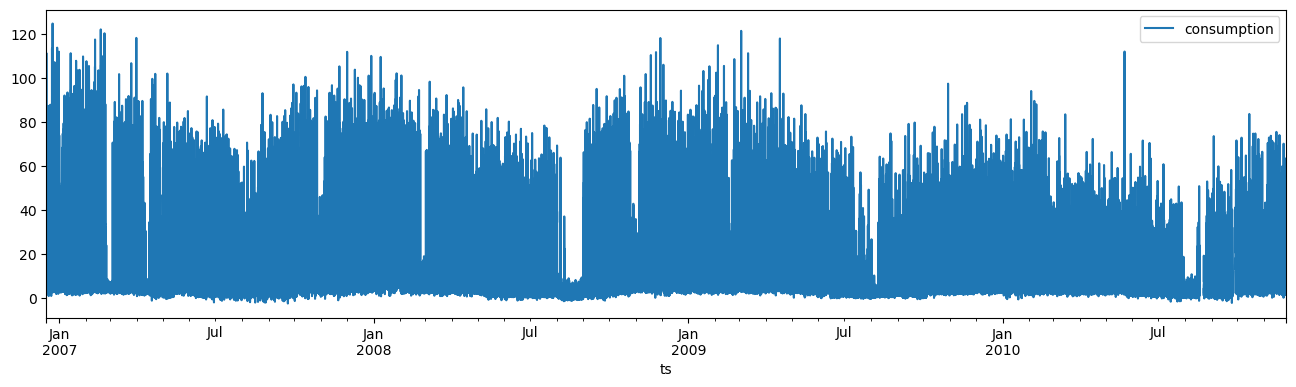

In [15]:
power.plot(figsize=(16,4));

Compare this to our *unformatted* data, which does not use the time data as the index:

<AxesSubplot:xlabel='ts'>

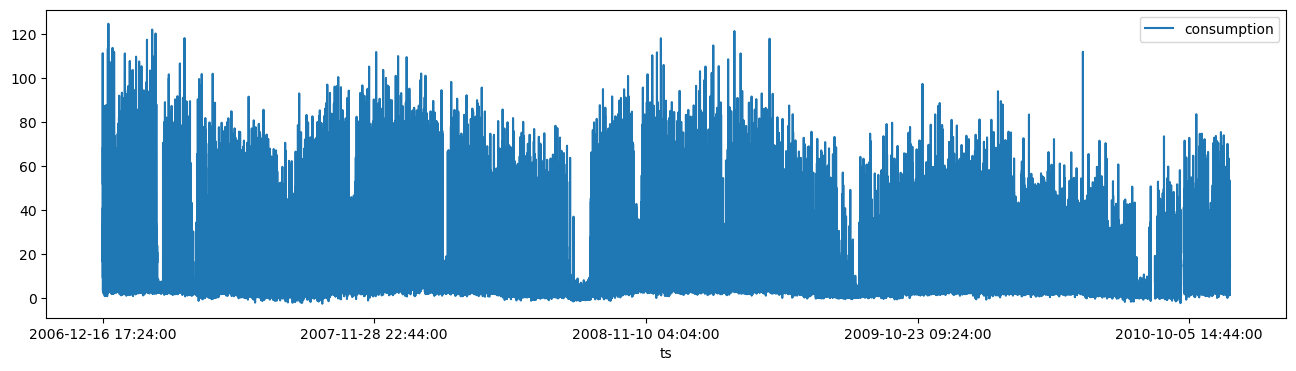

In [16]:
power_unformatted.plot(x = 'ts', y = 'consumption', figsize=(16,4))

Note how the x-axis is no longer nicely formatted? Pandas reads them as strings and will select x-ticks based on even intervals.

We may also want to do some histograms to see how our data is distributed. 

Let's look at the 2006 and 2007 - do you notice a difference?

In [20]:
power.loc['2007']

,consumption
ts,
2007-01-01 00:00:00,43.000000
2007-01-01 00:01:00,42.533333
2007-01-01 00:02:00,42.500000
2007-01-01 00:03:00,42.500000
2007-01-01 00:04:00,42.566667
...,...
2007-12-31 23:55:00,11.100000
2007-12-31 23:56:00,10.866667
2007-12-31 23:57:00,10.866667


<AxesSubplot:ylabel='Frequency'>

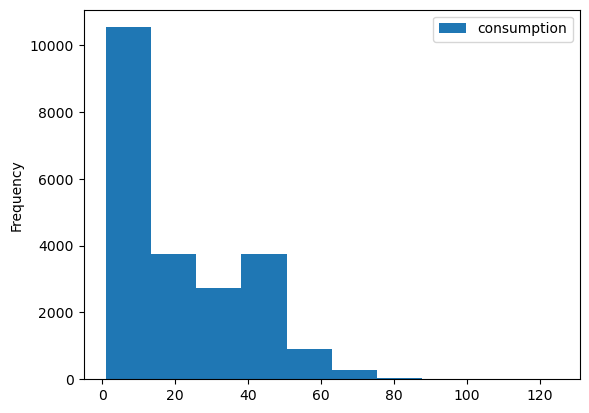

In [17]:
power.loc['2006'].plot(kind='hist')

<AxesSubplot:ylabel='Frequency'>

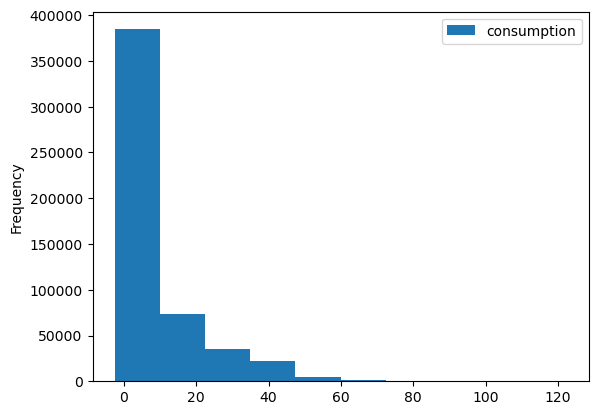

In [18]:
power.loc['2007'].plot(kind='hist')

<a id='agg1'></a>

## Aggregations: `resample()`

Another advantage of the datetime-index approach is that it provides us with some functionality for easy time-based aggregations. One such aggregation is `resample`. 

For example, we can easily calculate the _mean_ per _year_ by running:

In [21]:
power.resample('Y').mean()

,consumption
ts,
2006-12-31,20.815071
2007-12-31,9.952777
2008-12-31,9.468517
2009-12-31,8.881881
2010-12-31,8.350096


You can also run the same aggregation per month `M`, week `W`, day `D` or quarter `Q`. Custom aggregation periods are also possible, for example per 4 weeks `4W` or per 3 months `3M`. See [here] for a more comprehensive list of offsets, that can be as specific as _'Business Month Begin'_.

[here]: https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects

If the index is a timestamp that also includes times, then you can also aggregate per hour. The script below demonstrates this by calculating the mean per 3 hours.

In [22]:
power.resample('3H').mean().head()

,consumption
ts,
2006-12-16 15:00:00,52.992593
2006-12-16 18:00:00,37.733333
2006-12-16 21:00:00,33.228889
2006-12-17 00:00:00,29.128519
2006-12-17 03:00:00,27.626111


In [23]:
power.resample('3H').sum().head()

,consumption
ts,
2006-12-16 15:00:00,1907.733333
2006-12-16 18:00:00,6792.000000
2006-12-16 21:00:00,5981.200000
2006-12-17 00:00:00,5243.133333
2006-12-17 03:00:00,4972.700000


We can also use general `.agg()` methods here to apply multiple aggregators.

In [ ]:
power.resample('M').agg([('monthly_mean','mean'),('monthly_var','var'),('monthly_spread', lambda month_df: month_df.max() - month_df.min())])
    #.droplevel(0, axis=1)
    .head()

In [24]:
(
    power
    .resample('M')
    .agg([
        ('monthly_mean','mean'),
        ('monthly_var','var'),
        ('monthly_spread', lambda month_df: month_df.max() - month_df.min())
    ])
    #.droplevel(0, axis=1)
    .head()

)

consumption                           
           monthly_mean monthly_var monthly_spread
ts                                                
2006-12-31    20.815071  295.982325     123.800000
2007-01-31    15.343714  196.844106     110.133333
2007-02-28    13.865257  200.582017     120.800000
2007-03-31    11.764254  146.326263     116.733333
2007-04-30     8.013774   77.076019     103.066667

<a id='agg2'></a>

## Aggregations: `transform()`

Notice how aggregating results in a smaller DataFrame than before.

In [25]:
print(power.shape)

(2075259, 1)


In [26]:
print((
    power
    .resample('Y')
    .agg('mean')   
).shape)

(5, 1)


In [27]:
print((
    power
    .resample('M')
    .agg('mean')   
).shape)

(48, 1)


Using `transform()` allows to keep the original range of indices (in seconds) after aggregation. Resulting aggregated statistics then are the same for each aggregation period (each hour in our case):

In [28]:
(
    power
    .resample('M')
    .transform('mean')   
)

,consumption
ts,
2006-12-16 17:24:00,20.815071
2006-12-16 17:25:00,20.815071
2006-12-16 17:26:00,20.815071
2006-12-16 17:27:00,20.815071
2006-12-16 17:28:00,20.815071
...,...
2010-11-26 20:58:00,10.942476
2010-11-26 20:59:00,10.942476
2010-11-26 21:00:00,10.942476


In [29]:
print((
    power
    .resample('M')
    .transform('mean')   
).shape)

(2075259, 1)


Using this with the `assign` method allows us to add new columns to the original dataset.

In [30]:
(
    power
    .assign(monthly_mean = power.resample('M')['consumption'].transform('mean'),
           monthly_var = power.resample('M')['consumption'].transform('var'),
           monthly_spread = power.resample('M')['consumption'].transform(
               lambda month_df: month_df.max() - month_df.min())
           )
)

,consumption,monthly_mean,monthly_var,monthly_spread
ts,,,,
2006-12-16 17:24:00,52.266667,20.815071,295.982325,123.800000
2006-12-16 17:25:00,72.333333,20.815071,295.982325,123.800000
2006-12-16 17:26:00,70.566667,20.815071,295.982325,123.800000
2006-12-16 17:27:00,71.800000,20.815071,295.982325,123.800000
2006-12-16 17:28:00,43.100000,20.815071,295.982325,123.800000
...,...,...,...,...
2010-11-26 20:58:00,15.766667,10.942476,78.889362,75.366667
2010-11-26 20:59:00,15.733333,10.942476,78.889362,75.366667
2010-11-26 21:00:00,15.633333,10.942476,78.889362,75.366667


<a id='as'></a>
## <mark>Exercise: Resampling

Transform the dataset into consecutive five-day-periods:

- Show the total energy used in the five-day-periods

- Find the five-day-period in which the most energy is consumed in total




In [38]:
(
    power
    .assign(total_5_days = power.resample('5D')['consumption'].transform('sum'))
    .sort_values('total_5_days', ascending=False)
    .head(10)
)

,consumption,total_5_days
ts,,
2006-12-22 19:02:00,55.966667,160094.0
2006-12-22 21:06:00,26.533333,160094.0
2006-12-22 21:40:00,64.500000,160094.0
2006-12-22 21:41:00,63.133333,160094.0
2006-12-22 21:42:00,65.966667,160094.0
2006-12-22 21:43:00,65.266667,160094.0
2006-12-22 21:44:00,65.833333,160094.0
2006-12-22 21:45:00,37.200000,160094.0
2006-12-22 21:46:00,33.800000,160094.0


In [44]:
# %load answers/power-resampling.py
(
    power
    .resample('5D')
    .sum()
    #.sort_values("consumption", ascending=False)
    .loc[lambda df: df['consumption'] == df['consumption'].max()]
)


,consumption
ts,
2006-12-21,160094.0


<a id='sum'></a>
## Summary

We have covered: 
- How to properly read in time series data in Pandas, and why it is important to set the date as an index
- How to aggregate over time periods with Pandas
